In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns




from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('max_columns', None)
pd.set_option("max_rows", 100)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-card-default-prediction/train.csv
/kaggle/input/credit-card-default-prediction/test.csv


In [2]:
train = pd.read_csv(r'/kaggle/input/credit-card-default-prediction/train.csv')
test = pd.read_csv(r'/kaggle/input/credit-card-default-prediction/test.csv')

In [3]:
def assign_columns(df, is_training=True):
    """Assign column names for the data set."""
    col_list = ['customer_id', 'credit_line', 'gender', 'education', 'marital_status', 'age',
                'pay_09_2005', 'pay_08_2005', 'pay_07_2005', 'pay_06_2005', 'pay_05_2005', 'pay_04_2005', 
                'bill_state_09_2005', 'bill_state_08_2005', 'bill_state_07_2005', 'bill_state_06_2005', 'bill_state_05_2005', 'bill_state_04_2005',
                'pay_amount_09_2005', 'pay_amount_08_2005', 'pay_amount_07_2005', 'pay_amount_06_2005', 'pay_amount_05_2005', 'pay_amount_04_2005',
                'is_default']
    if is_training:
        assert len(df.columns) == 25, 'number of column names not match...'
        df.columns = col_list
        
    else:
        assert len(df.columns) == 24, 'number of column names not match...'
        df.columns = col_list[:-1]
    
    return df

train = assign_columns(train)
test = assign_columns(test, is_training=False)

In [4]:
train.head()

,customer_id,credit_line,gender,education,marital_status,age,pay_09_2005,pay_08_2005,pay_07_2005,pay_06_2005,pay_05_2005,pay_04_2005,bill_state_09_2005,bill_state_08_2005,bill_state_07_2005,bill_state_06_2005,bill_state_05_2005,bill_state_04_2005,pay_amount_09_2005,pay_amount_08_2005,pay_amount_07_2005,pay_amount_06_2005,pay_amount_05_2005,pay_amount_04_2005,is_default
0,1,200000,2,3,1,53,0,0,0,0,0,0,126027,129008,130376,133207,136159,138741,6500,5000,5000,5100,5000,5400,0
1,2,130000,2,3,2,39,0,0,0,2,0,0,133825,134495,133745,130814,130758,123468,7500,10000,0,4500,4500,4179,0
2,3,350000,2,1,2,41,0,0,0,0,0,0,122017,121505,119522,119947,117328,118400,6000,5900,5800,4100,4500,5000,0
3,4,240000,2,2,1,43,1,-2,-2,-1,0,0,0,0,0,12700,12500,26225,0,0,12700,0,13725,0,0
4,5,180000,1,2,2,28,-1,-1,-1,-1,-1,-1,1832,0,832,332,416,416,0,416,332,500,3500,832,0


### Business Understanding

### Data Understanding & Processing

In [5]:
# customer - credit lines
cust_line = train.groupby(['customer_id'])['credit_line'].nunique().reset_index().rename(columns={'credit_line':'num_lines'})
print('The max number of credit lines a customer holds is', cust_line['num_lines'].max())

The max number of credit lines a customer holds is 1


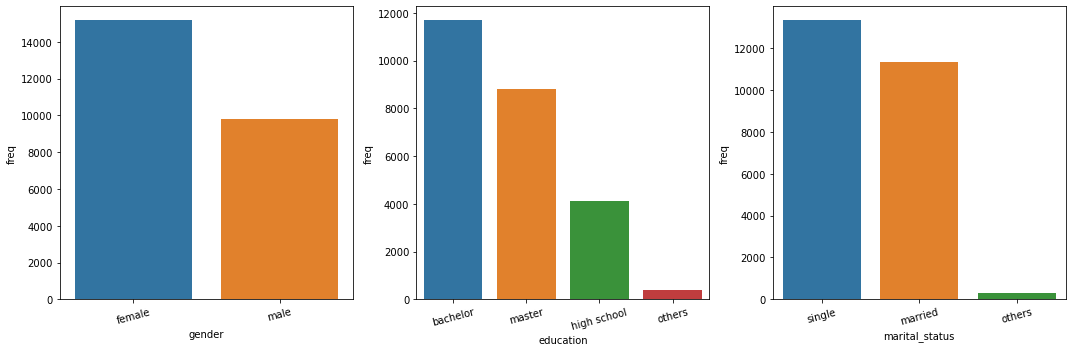

In [6]:
# gender, education, marital status 
# they all ordinal columns, to convert them into categorical features
train['gender'] = train['gender'].replace({1:'male', 2:'female'})
train['education'] = train['education'].replace({0:'others', 1:'master', 2:'bachelor', 3:'high school', 4:'others', 5:'others', 6:'others'})
train['marital_status'] = train['marital_status'].replace({0:'others', 1:'married', 2:'single', 3:'others'})

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.barplot(data=train['gender'].value_counts().reset_index().rename(columns={'index':'gender', 'gender':'freq'}), x='gender', y='freq', ax=ax1)
sns.barplot(data=train['education'].value_counts().reset_index().rename(columns={'index':'education', 'education':'freq'}), x='education', y='freq', ax=ax2)
sns.barplot(data=train['marital_status'].value_counts().reset_index().rename(columns={'index':'marital_status', 'marital_status':'freq'}), x='marital_status', y='freq', ax=ax3)

for ax in (ax1, ax2, ax3):
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=15)
fig.tight_layout()

<AxesSubplot:xlabel='age', ylabel='Count'>

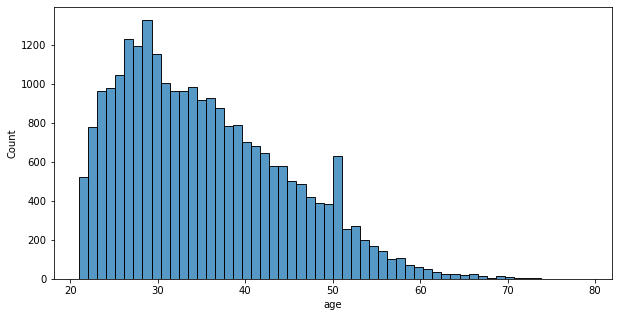

In [7]:
# age
assert train['age'].dtype == int

plt.figure(figsize=(10, 5))
sns.histplot(data=train, x='age', bins=train['age'].nunique())

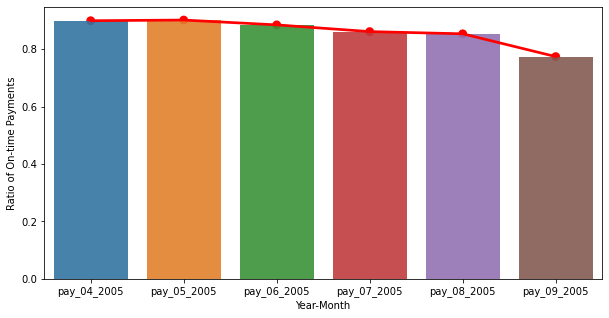

In [8]:
# pay, bill statement, pay amount
# note: payment follows the bill statement, usually payment on the following month means pay 2 month ahead
on_time_ratio = pd.DataFrame(np.zeros((6, 2)), columns=['y_m', 'pay_on_time'])
on_time_ratio['y_m'] = ['pay_04_2005', 'pay_05_2005', 'pay_06_2005', 'pay_07_2005', 'pay_08_2005', 'pay_09_2005']
on_time_ratio.iloc[0, 1] = train['pay_04_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]
on_time_ratio.iloc[1, 1] = train['pay_05_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]
on_time_ratio.iloc[2, 1] = train['pay_06_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]
on_time_ratio.iloc[3, 1] = train['pay_07_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]
on_time_ratio.iloc[4, 1] = train['pay_08_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]
on_time_ratio.iloc[5, 1] = train['pay_09_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]

plt.figure(figsize=(10, 5))
sns.barplot(data=on_time_ratio, x='y_m', y='pay_on_time', alpha=0.9)
sns.pointplot(data=on_time_ratio, x='y_m', y='pay_on_time', color='red')
plt.xlabel('Year-Month')
plt.ylabel('Ratio of On-time Payments');

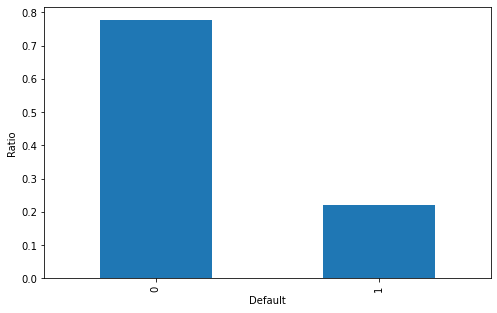

In [9]:
# default
plt.figure(figsize=(8, 5))
train['is_default'].value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Default')
plt.ylabel('Ratio');

### Modeling

In [10]:
# set customer id and credit line as index
try:
    train = train.set_index(keys=['customer_id', 'credit_line'])
except:
    pass

# convert categorical features into binary features
if 'gender_female' not in train.columns:
    train = pd.concat([train, pd.get_dummies(train[['gender', 'education', 'marital_status']])], axis=1)
train = train.drop(columns=['gender', 'education', 'marital_status'], errors='ignore')

# normalization & standardization
std_scaler = StandardScaler()
std_scaler.fit(train.drop(columns=['is_default']))
X_train_std_scale = pd.DataFrame(std_scaler.transform(train.drop(columns=['is_default'])), columns=train.drop(columns=['is_default']).columns)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X_train_std_scale,
                                                    train['is_default'],
                                                    test_size=0.2,
                                                    random_state=42)
print('x train shape =', x_train.shape)
print('x test shape =', x_test.shape)

x train shape = (20000, 28)
x test shape = (5000, 28)


In [42]:
# configs
metrics_list = [
                'accuracy', 
                'balanced_accuracy', 
                #'top_k_accuracy',
                'precision', 
                'average_precision', 
                'recall',
                'f1', 
                #'f1_micro', 
                #'f1_macro', 
                #'f1_weighted', 
                #'f1_samples',
                'roc_auc',
                # 'roc_auc_ovr', 
                #'roc_auc_ovo', 
                #'roc_auc_ovr_weighted', 
                #'roc_auc_ovo_weighted',
                'jaccard',
                #'brier_score_loss', 
                #'neg_log_loss'
               ]
cv = 10
n_iter = 4

- Baseline: Logistic Regression

In [13]:
lr = LogisticRegression(random_state=42, max_iter=5000)
lr_results = cross_validate(lr, 
                            X=x_train,
                            y=y_train,
                            scoring=metrics_list,
                            cv=cv)
lr_results

{'fit_time': array([0.14948511, 0.12680197, 0.13664174, 0.15028214, 0.15253663,
        0.15267634, 0.15615654, 0.16927052, 0.13998079, 0.1721561 ]),
 'score_time': array([0.01817584, 0.01760435, 0.01747012, 0.01748967, 0.01751113,
        0.01840448, 0.01740885, 0.01773071, 0.01732326, 0.01815319]),
 'test_accuracy': array([0.805 , 0.808 , 0.811 , 0.81  , 0.8135, 0.8095, 0.797 , 0.81  ,
        0.809 , 0.8085]),
 'test_balanced_accuracy': array([0.60748859, 0.60056393, 0.60893027, 0.60345886, 0.61295132,
        0.60635668, 0.57991257, 0.60110553, 0.59885834, 0.60896347]),
 'test_precision': array([0.65882353, 0.71126761, 0.71710526, 0.72535211, 0.73202614,
        0.70860927, 0.65116279, 0.74074074, 0.73684211, 0.69375   ]),
 'test_average_precision': array([0.48846583, 0.48456374, 0.51379694, 0.50506826, 0.493801  ,
        0.53311298, 0.44794985, 0.51255762, 0.51524162, 0.52240292]),
 'test_recall': array([0.25225225, 0.22747748, 0.2454955 , 0.23198198, 0.25225225,
        0.240990

- Baseline: Decision Tree

In [14]:
dt = DecisionTreeClassifier(random_state=42)
dt_results = cross_validate(dt, 
                            X=x_train,
                            y=y_train,
                            scoring=metrics_list,
                            cv=cv)
dt_results

{'fit_time': array([0.48194861, 0.47185254, 0.47823095, 0.47293472, 0.48176551,
        0.48612857, 0.46074247, 0.47388434, 0.49692798, 0.45726895]),
 'score_time': array([0.02077603, 0.02067971, 0.0207088 , 0.01966786, 0.01907086,
        0.0208559 , 0.02044678, 0.0195775 , 0.01891184, 0.01929688]),
 'test_accuracy': array([0.7225, 0.708 , 0.716 , 0.7145, 0.7255, 0.7105, 0.7185, 0.723 ,
        0.706 , 0.7115]),
 'test_balanced_accuracy': array([0.60356018, 0.59021747, 0.59777322, 0.60324753, 0.60790257,
        0.60791994, 0.59680263, 0.61333141, 0.59036815, 0.61315438]),
 'test_precision': array([0.3785558 , 0.35294118, 0.36695279, 0.36907216, 0.38512035,
        0.36790607, 0.37004405, 0.38622129, 0.35196687, 0.37307692]),
 'test_average_precision': array([0.28348399, 0.2728013 , 0.27855703, 0.28200942, 0.28852751,
        0.28594215, 0.27913877, 0.29220919, 0.27405344, 0.28962554]),
 'test_recall': array([0.38963964, 0.37837838, 0.38513514, 0.40315315, 0.3963964 ,
        0.423423

- Baseline: Random Forest

In [15]:
rf = RandomForestClassifier(random_state=42)
rf_results = cross_validate(rf, 
                            X=x_train,
                            y=y_train,
                            scoring=metrics_list,
                            cv=cv)
rf_results

{'fit_time': array([5.49853563, 5.67097759, 5.67930245, 5.59909248, 5.5463109 ,
        5.52033305, 5.51083994, 5.67788029, 5.5445354 , 5.75061131]),
 'score_time': array([0.15089655, 0.1595397 , 0.14836335, 0.14779711, 0.14505434,
        0.14828539, 0.14771342, 0.1485889 , 0.14966965, 0.16696668]),
 'test_accuracy': array([0.806 , 0.813 , 0.8145, 0.811 , 0.8235, 0.814 , 0.808 , 0.8175,
        0.8075, 0.804 ]),
 'test_balanced_accuracy': array([0.64434679, 0.64804071, 0.65383346, 0.6515841 , 0.66364147,
        0.6631696 , 0.64072401, 0.65966617, 0.63799631, 0.64697424]),
 'test_precision': array([0.60852713, 0.6446281 , 0.64541833, 0.62790698, 0.6872428 ,
        0.63043478, 0.62655602, 0.65748031, 0.62711864, 0.59778598]),
 'test_average_precision': array([0.5186109 , 0.51912946, 0.52087246, 0.51142366, 0.54910886,
        0.55143979, 0.4702704 , 0.50510493, 0.50656279, 0.50854106]),
 'test_recall': array([0.3536036 , 0.35135135, 0.36486486, 0.36486486, 0.37612613,
        0.391891

- Baseline: Gradient Boosting

In [16]:
gbc = GradientBoostingClassifier(random_state=42)
gbc_results = cross_validate(gbc, 
                             X=x_train,
                             y=y_train,
                             scoring=metrics_list,
                             cv=cv)
gbc_results

{'fit_time': array([7.41270876, 7.37614036, 7.46152639, 7.43506312, 7.35490489,
        7.44764018, 7.47158909, 7.40720224, 7.43518806, 7.42402458]),
 'score_time': array([0.02618051, 0.02773786, 0.02503896, 0.02450299, 0.02477956,
        0.02538419, 0.02466893, 0.02538753, 0.02444386, 0.02792549]),
 'test_accuracy': array([0.8145, 0.819 , 0.8205, 0.8145, 0.8195, 0.827 , 0.8055, 0.825 ,
        0.8155, 0.818 ]),
 'test_balanced_accuracy': array([0.65383346, 0.65028718, 0.65929908, 0.65141909, 0.65382767,
        0.67152435, 0.62868962, 0.66128112, 0.64153691, 0.65758156]),
 'test_precision': array([0.64541833, 0.68141593, 0.67489712, 0.64897959, 0.67811159,
        0.696     , 0.62727273, 0.70562771, 0.67592593, 0.66396761]),
 'test_average_precision': array([0.54786457, 0.54443057, 0.55204453, 0.54620107, 0.56070058,
        0.5819356 , 0.49936402, 0.58642038, 0.55248133, 0.53040975]),
 'test_recall': array([0.36486486, 0.34684685, 0.36936937, 0.35810811, 0.35585586,
        0.391891

- Baseline: XGB

In [17]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, booster='gbtree')
xgb_results = cross_validate(xgb, 
                             X=x_train,
                             y=y_train,
                             scoring=metrics_list,
                             cv=cv)
xgb_results

[20:22:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'fit_time': array([2.35431337, 2.29323006, 3.1102922 , 2.41984391, 2.26444864,
        2.25686646, 2.26354027, 2.29293871, 2.42111111, 2.28093672]),
 'score_time': array([0.02702022, 0.02575636, 0.02519345, 0.02597785, 0.02557659,
        0.02607584, 0.02563715, 0.02617359, 0.02500772, 0.02613497]),
 'test_accuracy': array([0.814 , 0.8095, 0.812 , 0.818 , 0.8125, 0.8115, 0.799 , 0.8125,
        0.8085, 0.806 ]),
 'test_balanced_accuracy': array([0.6551217 , 0.64096262, 0.64417888, 0.66010676, 0.64691459,
        0.65271023, 0.62450956, 0.64843022, 0.6370353 , 0.641844  ]),
 'test_precision': array([0.640625  , 0.63291139, 0.6440678 , 0.65748031, 0.64315353,
        0.62934363, 0.59227468, 0.64344262, 0.63478261, 0.61354582]),
 'test_average_precision': array([0.52869304, 0.52003706, 0.52144758, 0.54367452, 0.52738165,
        0.53136157, 0.46772783, 0.5199327 , 0.51264425, 0.5078461 ]),
 'test_recall': array([0.36936937, 0.33783784, 0.34234234, 0.37612613, 0.3490991 ,
        0.367117

- Baseline: Light BGM

In [18]:
lgbm = LGBMClassifier(random_state=42)
lgbm_results = cross_validate(lgbm, 
                              X=x_train,
                              y=y_train,
                              scoring=metrics_list,
                              cv=cv)
lgbm_results

{'fit_time': array([0.37979007, 0.33551025, 0.34088492, 0.33661318, 0.34170318,
        0.33380055, 0.33450127, 0.3408339 , 0.33994794, 0.35858655]),
 'score_time': array([0.02987266, 0.02979279, 0.02932358, 0.03013635, 0.02955317,
        0.03002477, 0.02925849, 0.03081059, 0.03006673, 0.0311563 ]),
 'test_accuracy': array([0.8125, 0.819 , 0.8235, 0.817 , 0.8185, 0.824 , 0.8055, 0.823 ,
        0.8145, 0.8145]),
 'test_balanced_accuracy': array([0.65254811, 0.64948239, 0.66364147, 0.64819704, 0.65559937,
        0.66718196, 0.63029372, 0.66159905, 0.64570613, 0.6529246 ]),
 'test_precision': array([0.63529412, 0.68303571, 0.6872428 , 0.67105263, 0.66804979,
        0.684     , 0.625     , 0.69037657, 0.66086957, 0.64919355]),
 'test_average_precision': array([0.54231013, 0.52992526, 0.54456374, 0.55209305, 0.53809332,
        0.57634783, 0.49076432, 0.55901192, 0.54621625, 0.53079224]),
 'test_recall': array([0.36486486, 0.34459459, 0.37612613, 0.34459459, 0.36261261,
        0.385135

- Baseline: SVM

In [19]:
svm = SVC(random_state=42)
svm_results = cross_validate(svm, 
                             X=x_train,
                             y=y_train,
                             scoring=metrics_list,
                             cv=cv)
svm_results

{'fit_time': array([18.19510055, 18.17029047, 18.25601101, 18.00637698, 18.09673715,
        17.92804694, 18.04619098, 17.91402483, 18.09262061, 18.54722118]),
 'score_time': array([2.90589786, 2.95557451, 2.92365694, 2.91080189, 2.92728806,
        2.92961597, 2.89832234, 2.92026401, 2.89331102, 2.92635679]),
 'test_accuracy': array([0.8125, 0.82  , 0.82  , 0.8165, 0.8165, 0.8225, 0.8025, 0.821 ,
        0.816 , 0.8175]),
 'test_balanced_accuracy': array([0.63806191, 0.63805322, 0.6469059 , 0.64465655, 0.64385176,
        0.65092696, 0.61713573, 0.63945952, 0.63223382, 0.64603129]),
 'test_precision': array([0.65753425, 0.71875   , 0.69626168, 0.67420814, 0.67579909,
        0.70697674, 0.62376238, 0.72774869, 0.70157068, 0.68181818]),
 'test_average_precision': array([0.50610176, 0.51149944, 0.52644011, 0.4921789 , 0.49586605,
        0.5411563 , 0.45192312, 0.51418049, 0.49932788, 0.51524658]),
 'test_recall': array([0.32432432, 0.31081081, 0.33558559, 0.33558559, 0.33333333,
      

In [20]:
def results_dict2df(results, clf_name):
    """convert model performance results dictionary into data frame."""
    results = pd.DataFrame(results)
    num_cv = results.shape[0]
    
    return pd.concat([pd.DataFrame(np.array([[clf_name] * num_cv, np.arange(1, num_cv + 1)]).T, columns=['model', 'cv_idx']), 
                                   results], axis=1)

baseline_results = pd.DataFrame()
for model, results in zip(['lr', 'dt', 'rf', 'gbc', 'xgb', 'lgbm', 'svm'], [lr_results, dt_results, rf_results, gbc_results, xgb_results, lgbm_results, svm_results]):
    baseline_results = pd.concat([baseline_results, results_dict2df(results, clf_name=model)], axis=0)
baseline_results

,model,cv_idx,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_precision,test_average_precision,test_recall,test_f1,test_roc_auc,test_jaccard
0,lr,1,0.149485,0.018176,0.8050,0.607489,0.658824,0.488466,0.252252,0.364821,0.732983,0.223108
1,lr,2,0.126802,0.017604,0.8080,0.600564,0.711268,0.484564,0.227477,0.344710,0.713557,0.208247
2,lr,3,0.136642,0.017470,0.8110,0.608930,0.717105,0.513797,0.245495,0.365772,0.716235,0.223819
3,lr,4,0.150282,0.017490,0.8100,0.603459,0.725352,0.505068,0.231982,0.351536,0.724756,0.213251
4,lr,5,0.152537,0.017511,0.8135,0.612951,0.732026,0.493801,0.252252,0.375209,0.696295,0.230928
5,lr,6,0.152676,0.018404,0.8095,0.606357,0.708609,0.533113,0.240991,0.359664,0.737434,0.219262
6,lr,7,0.156157,0.017409,0.7970,0.579913,0.651163,0.447950,0.188764,0.292683,0.689040,0.171429
7,lr,8,0.169271,0.017731,0.8100,0.601106,0.740741,0.512558,0.224719,0.344828,0.725984,0.208333
8,lr,9,0.139981,0.017323,0.8090,0.598858,0.736842,0.515242,0.220225,0.339100,0.717709,0.204167
9,lr,10,0.172156,0.018153,0.8085,0.608963,0.693750,0.522403,0.249438,0.366942,0.730914,0.224696


- Model Performance Comparison 
    - on the one hand, since the train set global default rate is 22.19%, which is imbalanced, metrics that are threshold insensitive are prefered: *Average Precision, ROC-AUC*
    - on the other hand, metrics that consider True Positives and True Negatives at the same time, but separately, are prefered: *Balanced Accuracy, F1, Jaccard*

Cross Validation to Find the Best Baseline by Metric
best model for Accuracy: gbc, 81.79%
best model for Balanced Accuracy: gbc, 65.29% *
best model for Precision: lr, 70.76%
best model for Average Precision: gbc, 55.02% **
best model for Recall: dt, 39.87%
best model for F1: gbc, 46.46% *
best model for ROC-AUC: gbc, 77.03% **
best model for Jaccard: gbc, 30.29% *


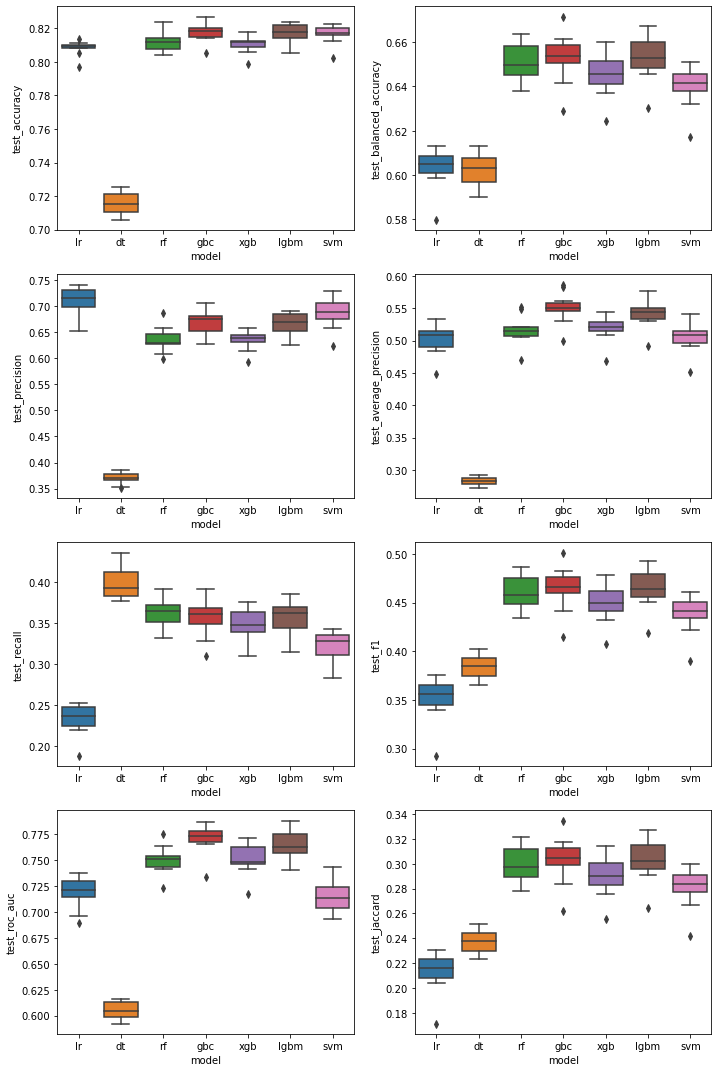

In [21]:
# max scores 
print('Cross Validation to Find the Best Baseline by Metric')
print('best model for Accuracy: {:s}, {:.2%}'.format(baseline_results.groupby(['model'])['test_accuracy'].mean().sort_values(ascending=False).index[0], 
                                                     baseline_results.groupby(['model'])['test_accuracy'].mean().sort_values(ascending=False)[0]))
print('best model for Balanced Accuracy: {:s}, {:.2%} *'.format(baseline_results.groupby(['model'])['test_balanced_accuracy'].mean().sort_values(ascending=False).index[0], 
                                                                baseline_results.groupby(['model'])['test_balanced_accuracy'].mean().sort_values(ascending=False)[0]))
print('best model for Precision: {:s}, {:.2%}'.format(baseline_results.groupby(['model'])['test_precision'].mean().sort_values(ascending=False).index[0], 
                                                      baseline_results.groupby(['model'])['test_precision'].mean().sort_values(ascending=False)[0]))
print('best model for Average Precision: {:s}, {:.2%} **'.format(baseline_results.groupby(['model'])['test_average_precision'].mean().sort_values(ascending=False).index[0], 
                                                                 baseline_results.groupby(['model'])['test_average_precision'].mean().sort_values(ascending=False)[0]))
print('best model for Recall: {:s}, {:.2%}'.format(baseline_results.groupby(['model'])['test_recall'].mean().sort_values(ascending=False).index[0], 
                                                   baseline_results.groupby(['model'])['test_recall'].mean().sort_values(ascending=False)[0]))
print('best model for F1: {:s}, {:.2%} *'.format(baseline_results.groupby(['model'])['test_f1'].mean().sort_values(ascending=False).index[0], 
                                                 baseline_results.groupby(['model'])['test_f1'].mean().sort_values(ascending=False)[0]))
print('best model for ROC-AUC: {:s}, {:.2%} **'.format(baseline_results.groupby(['model'])['test_roc_auc'].mean().sort_values(ascending=False).index[0], 
                                                       baseline_results.groupby(['model'])['test_roc_auc'].mean().sort_values(ascending=False)[0]))
print('best model for Jaccard: {:s}, {:.2%} *'.format(baseline_results.groupby(['model'])['test_jaccard'].mean().sort_values(ascending=False).index[0], 
                                                      baseline_results.groupby(['model'])['test_jaccard'].mean().sort_values(ascending=False)[0]))

# visualize test accuracy
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))
sns.boxplot(data=baseline_results, x='model', y='test_accuracy', ax=ax1)
sns.boxplot(data=baseline_results, x='model', y='test_balanced_accuracy', ax=ax2)
sns.boxplot(data=baseline_results, x='model', y='test_precision', ax=ax3)
sns.boxplot(data=baseline_results, x='model', y='test_average_precision', ax=ax4)
sns.boxplot(data=baseline_results, x='model', y='test_recall', ax=ax5)
sns.boxplot(data=baseline_results, x='model', y='test_f1', ax=ax6)
sns.boxplot(data=baseline_results, x='model', y='test_roc_auc', ax=ax7)
sns.boxplot(data=baseline_results, x='model', y='test_jaccard', ax=ax8)
fig.tight_layout()


In [22]:
print('Based on 10-fold cross validation results, Gradient Boosting Classifier is selected as the baseline model.')
print('Average Precision and ROC-AUC will be used as the model performance metrics.')

Based on 10-fold cross validation results, Gradient Boosting Classifier is selected as the baseline model.
Average Precision and ROC-AUC will be used as the model performance metrics.


### Hyperparameter Tuning on Gradient Boosting Classifier

In [79]:
params = {'loss': ['deviance', 'exponential'],
          'learning_rate': [0.01, 0.1, 1],
          'n_estimators': [100, 200, 500],
          'subsample': [0.5, 0.8, 1], 
          'max_features': ['auto', 'sqrt', 'log2'],
          'criterion':['friedman_mse', 'mse'],
          }
cv = 10
n_iter = 1000

In [80]:
tuner = RandomizedSearchCV(estimator=gbc,
                           param_distributions=params,
                           n_iter=n_iter, 
                           scoring=['average_precision', 'roc_auc'],
                           cv=cv, 
                           verbose=1,
                           refit=False,
                           error_score=-1,
                           return_train_score=False,
                           n_jobs=-1)

tuner.fit(x_train, y_train)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 324 is smaller than n_iter=1000. Running 324 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=10, error_score=-1,
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse', 'mse'],
                                        'learning_rate': [0.01, 0.1, 1],
                                        'loss': ['deviance', 'exponential'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 500],
                                        'subsample': [0.5, 0.8, 1]},
                   refit=False, scoring=['average_precision', 'roc_auc'],
                   verbose=1)

In [81]:
"""
['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_subsample',
 'param_n_estimators',
 'param_max_features',
 'param_loss',
 'param_learning_rate',
 'param_criterion',
 'params',
 'split0_test_average_precision',
 'split1_test_average_precision',
 'split2_test_average_precision',
 'split3_test_average_precision',
 'mean_test_average_precision',
 'std_test_average_precision',
 'rank_test_average_precision',
 'split0_test_roc_auc',
 'split1_test_roc_auc',
 'split2_test_roc_auc',
 'split3_test_roc_auc',
 'mean_test_roc_auc',
 'std_test_roc_auc',
 'rank_test_roc_auc']
"""

"\n['mean_fit_time',\n 'std_fit_time',\n 'mean_score_time',\n 'std_score_time',\n 'param_subsample',\n 'param_n_estimators',\n 'param_max_features',\n 'param_loss',\n 'param_learning_rate',\n 'param_criterion',\n 'params',\n 'split0_test_average_precision',\n 'split1_test_average_precision',\n 'split2_test_average_precision',\n 'split3_test_average_precision',\n 'mean_test_average_precision',\n 'std_test_average_precision',\n 'rank_test_average_precision',\n 'split0_test_roc_auc',\n 'split1_test_roc_auc',\n 'split2_test_roc_auc',\n 'split3_test_roc_auc',\n 'mean_test_roc_auc',\n 'std_test_roc_auc',\n 'rank_test_roc_auc']\n"

In [87]:
average_precision_results = pd.DataFrame(np.array([tuner.cv_results_['split' + str(i) + '_test_average_precision'] for i in range(cv)]), 
                                         index=['cv_'+ str(i) for i in range(cv)], 
                                         columns=['params_' + str(i) for i in range(min(n_iter, len(tuner.cv_results_['params'])))])
average_precision_results

,params_0,params_1,params_2,params_3,params_4,params_5,params_6,params_7,params_8,params_9,params_10,params_11,params_12,params_13,params_14,params_15,params_16,params_17,params_18,params_19,params_20,params_21,params_22,params_23,params_24,params_25,params_26,params_27,params_28,params_29,params_30,params_31,params_32,params_33,params_34,params_35,params_36,params_37,params_38,params_39,params_40,params_41,params_42,params_43,params_44,params_45,params_46,params_47,params_48,params_49,params_50,params_51,params_52,params_53,params_54,params_55,params_56,params_57,params_58,params_59,params_60,params_61,params_62,params_63,params_64,params_65,params_66,params_67,params_68,params_69,params_70,params_71,params_72,params_73,params_74,params_75,params_76,params_77,params_78,params_79,params_80,params_81,params_82,params_83,params_84,params_85,params_86,params_87,params_88,params_89,params_90,params_91,params_92,params_93,params_94,params_95,params_96,params_97,params_98,params_99,params_100,params_101,params_102,params_103,params_104,params_105,params_106,params_107,params_108,params_109,params_110,params_111,params_112,params_113,params_114,params_115,params_116,params_117,params_118,params_119,params_120,params_121,params_122,params_123,params_124,params_125,params_126,params_127,params_128,params_129,params_130,params_131,params_132,params_133,params_134,params_135,params_136,params_137,params_138,params_139,params_140,params_141,params_142,params_143,params_144,params_145,params_146,params_147,params_148,params_149,params_150,params_151,params_152,params_153,params_154,params_155,params_156,params_157,params_158,params_159,params_160,params_161,params_162,params_163,params_164,params_165,params_166,params_167,params_168,params_169,params_170,params_171,params_172,params_173,params_174,params_175,params_176,params_177,params_178,params_179,params_180,params_181,params_182,params_183,params_184,params_185,params_186,params_187,params_188,params_189,params_190,params_191,params_192,params_193,params_194,params_195,params_196,params_197,params_198,params_199,params_200,params_201,params_202,params_203,params_204,params_205,params_206,params_207,params_208,params_209,params_210,params_211,params_212,params_213,params_214,params_215,params_216,params_217,params_218,params_219,params_220,params_221,params_222,params_223,params_224,params_225,params_226,params_227,params_228,params_229,params_230,params_231,params_232,params_233,params_234,params_235,params_236,params_237,params_238,params_239,params_240,params_241,params_242,params_243,params_244,params_245,params_246,params_247,params_248,params_249,params_250,params_251,params_252,params_253,params_254,params_255,params_256,params_257,params_258,params_259,params_260,params_261,params_262,params_263,params_264,params_265,params_266,params_267,params_268,params_269,params_270,params_271,params_272,params_273,params_274,params_275,params_276,params_277,params_278,params_279,params_280,params_281,params_282,params_283,params_284,params_285,params_286,params_287,params_288,params_289,params_290,params_291,params_292,params_293,params_294,params_295,params_296,params_297,params_298,params_299,params_300,params_301,params_302,params_303,params_304,params_305,params_306,params_307,params_308,params_309,params_310,params_311,params_312,params_313,params_314,params_315,params_316,params_317,params_318,params_319,params_320,params_321,params_322,params_323
cv_0,0.537178,0.533858,0.529312,0.544889,0.540367,0.538478,0.551218,0.551172,0.548757,0.529190,0.523963,0.534556,0.532212,0.534485,0.540822,0.542414,0.542292,0.545807,0.531417,0.527739,0.520610,0.533296,0.531217,0.527154,0.539800,0.541760,0.540256,0.539799,0.535205,0.528115,0.543927,0.540537,0.538176,0.550294,0.546796,0.546196,0.528482,0.524240,0.533119,0.532158,0.535827,0.537396,0.539894,0.539031,0.543631,0.523192,0.525353,0.522348,0.529763,0.531102,0.528367,0.536915,0.537685,0.539441,0.543858,0.554895,0.547865,0.534386,0.543638,0.545587,

In [ ]:
roc_auc_results = pd.DataFrame(np.array([tuner.cv_results_['split' + str(i) + '_test_roc_auc'] for i in range(cv)]), 
                               index=['cv_'+ str(i) for i in range(cv)], 
                               columns=['params_' + str(i) for i in range(min(n_iter, len(tuner.cv_results_['params'])))])
roc_auc_results

In [ ]:
print('max Mean Average Precision =', np.round(max(average_precision_results.mean()), 3))
print('best params({:d}): {}'.format(np.argmax(average_precision_results.mean()), tuner.cv_results_['params'][np.argmax(average_precision_results.mean())]))

In [ ]:
print('max Mean ROC-AUC =', np.round(max(roc_auc_results.mean()), 3))
print('best params({:d}): {}'.format(np.argmax(roc_auc_results.mean()), tuner.cv_results_['params'][np.argmax(roc_auc_results.mean())]))